In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import network_fcn as vae
import SiameseNetwork3_3 as smsn
import argparse
import pickle
from keras.layers import concatenate, Flatten
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy import spatial
import os
from os.path import dirname, abspath
from utils import *
from itertools import combinations
from plotnine import ggplot, aes, geom_point,labs, scale_size, theme, element_text, stat_summary, scale_colour_gradient, scale_colour_gradient2, geom_boxplot
import warnings
import Classify as cls

## initialize hyperparameters

In [2]:
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [3]:
parser = argparse.ArgumentParser(description='')
parser.add_argument('--input_size', dest='input_size', default= (None, 1))
parser.add_argument('--batch_shape', dest='batch_shape', default=8)
parser.add_argument('--latent_shape', dest='latent_shape', default=128)
parser.add_argument('--para_shape', dest='para_shape', default=15)
parser.add_argument('--batch_size', dest='batch_size', type=int, default=64)
parser.add_argument('--epochs', dest='epochs', type=int, default=50)
parser.add_argument('--step_decay', dest='step_decay', type=int, default=5)
parser.add_argument('--patience', dest='patience', type=int, default=10)
parser.add_argument('--lr', dest='lr', type=float, default=0.00005)
parser.add_argument('--dec_loss', dest='dec_loss', default=vae.loss().loss_vae)
parser.add_argument('--dis_loss', dest='dis_loss', default=vae.loss().loss_bce)
parser.add_argument('--cls_loss', dest='cls_loss', default=vae.loss().loss_bce)
parser.add_argument('--beta_1', dest='beta_1', type=float, default=0.5)
parser.add_argument('--norm', dest='norm', default='batch_norm')
parser.add_argument('--n_down', dest='n_down', default=7)
parser.add_argument('--n_std', dest='n_std', default=0.15)
parser.add_argument('--batch', dest='batch', default=False)
parser.add_argument('--n_group', dest='n_group', default=4)
args, unknown = parser.parse_known_args()

In [4]:
metadata = pd.read_csv(dirname(abspath(os.getcwd())) + '/datasets/bacterial_SSP/metadata.csv')
spec = pd.read_csv(dirname(abspath(os.getcwd())) + '/datasets/bacterial_SSP/data.csv')
wn = np.array(spec.iloc[0,1:])
spec = np.array(spec.iloc[1:,1:])
labels = np.array(metadata['labels'])
batches = np.array(metadata['batches'])

ix_wn = np.asarray(range(len(wn)))[(wn>1850) & (wn<2750)]
ix_wn1 = np.asarray(range(len(wn)))[(wn<1800) | (wn>2800)]

for i in range(spec.shape[0]):
    spec[i,:] = spec[i, :]/np.max(spec[i, :])

ix = np.argwhere((labels != 'L-innocua') & (labels != 'P-stutzeri'))[:,0]
spec = spec[ix, :]
labels = labels[ix]
batches = batches[ix]

corr_all = np.mean(np.corrcoef(spec), 0)
i_good = corr_all>np.percentile(corr_all, 1)
spec = spec[i_good, :]
labels = labels[i_good]
batches = batches[i_good]

uni_labels = np.unique(labels)
dummy_y = np.zeros((len(labels), len(uni_labels)))
for i in range(len(uni_labels)):
    dummy_y[labels==uni_labels[i], i] = 1

n_spec_gen = 60

[0 1 2 3 4 5 6 7]
1582/1582 [==============================] - 5003s 3s/step


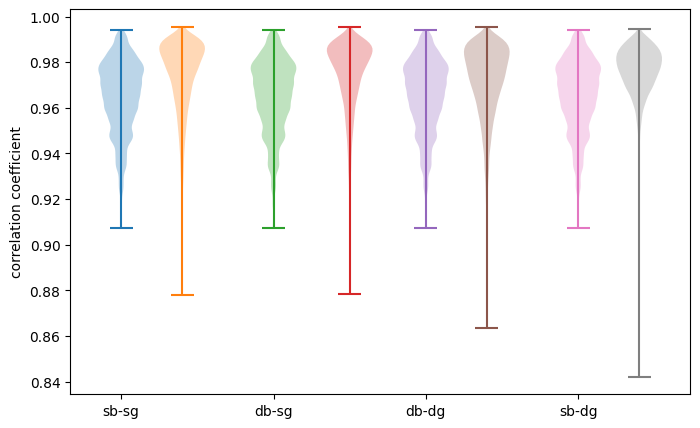

intermediate results:


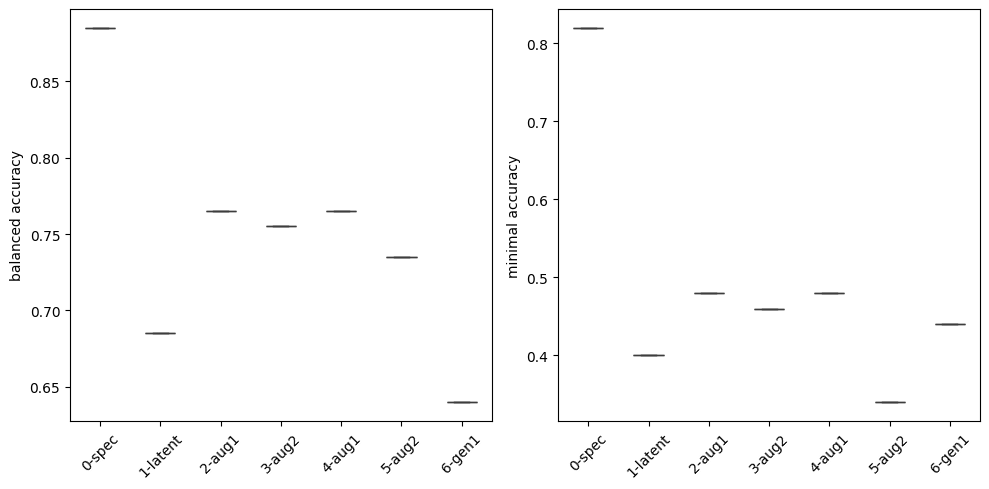

[0 1 2 3 4 5 6 8]
1579/1579 [==============================] - 6505s 4s/step


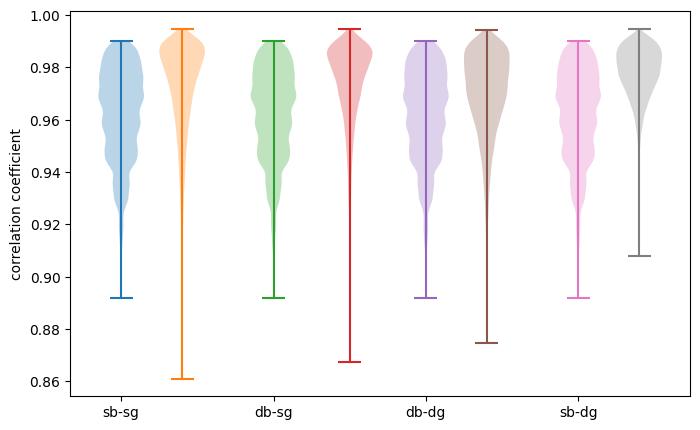

intermediate results:


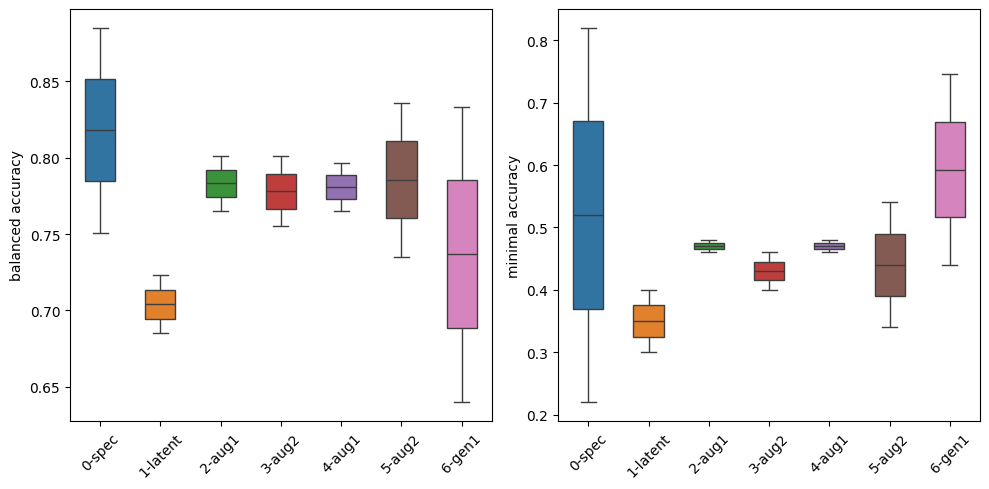

[0 1 2 3 4 5 7 8]
1583/1583 [==============================] - 8747s 6s/step


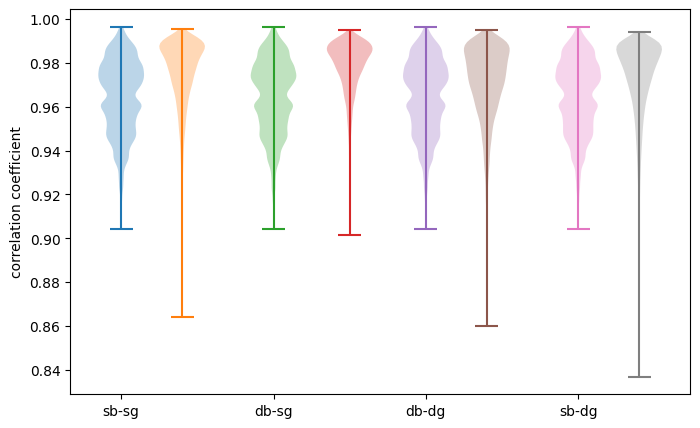

intermediate results:


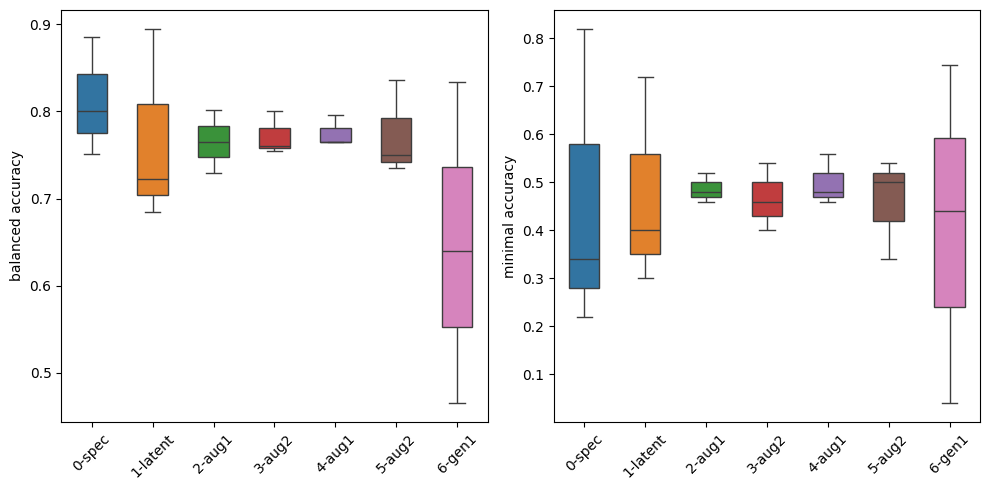

[0 1 2 3 4 6 7 8]
1599/1599 [==============================] - 11802s 7s/step


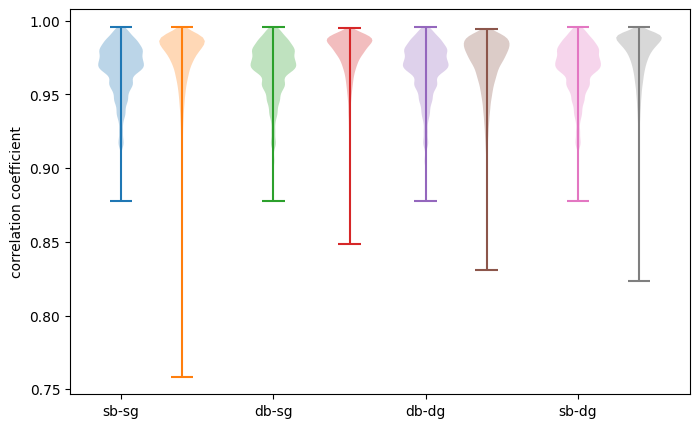

intermediate results:


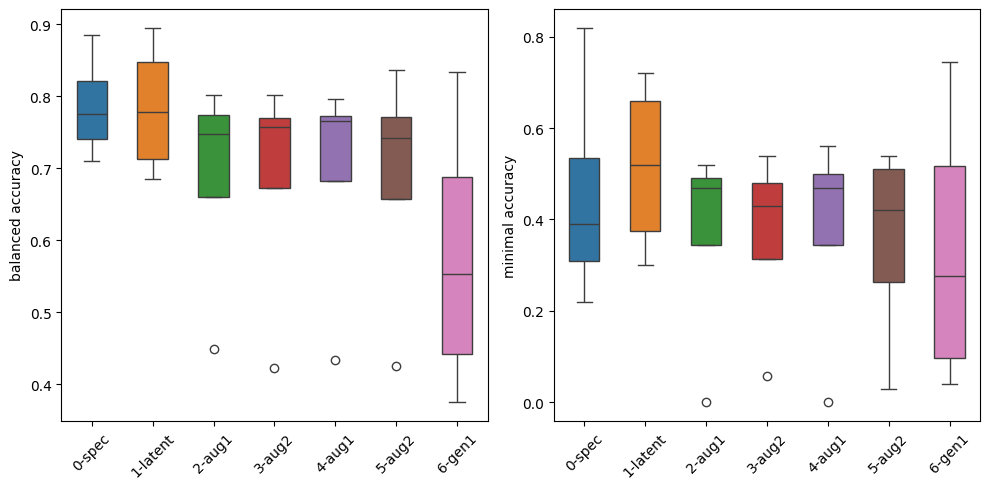

[0 1 2 3 5 6 7 8]
1584/1584 [==============================] - 14716s 9s/step


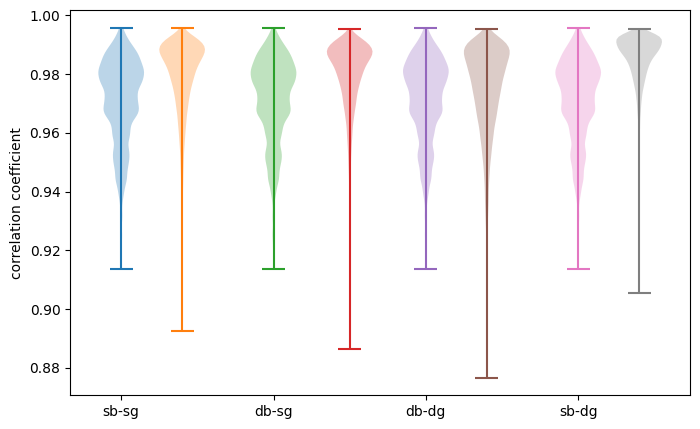

intermediate results:


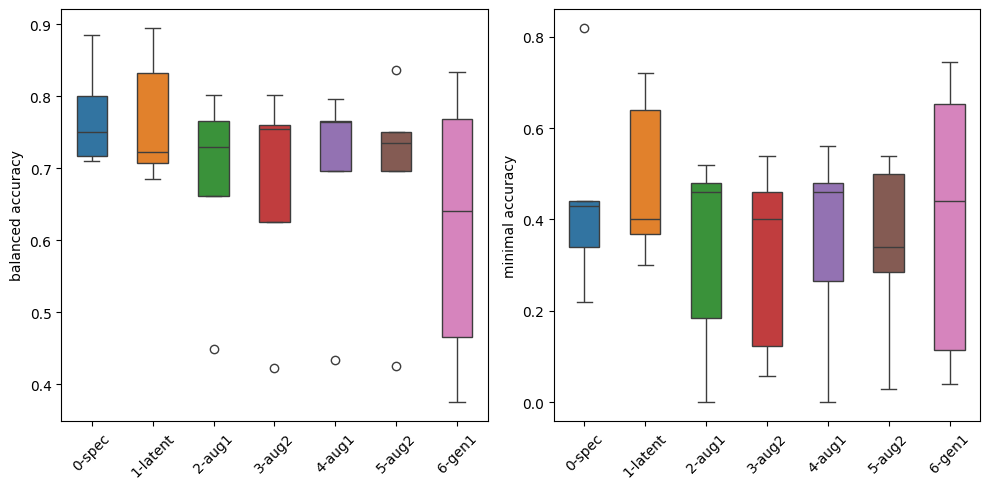

[0 1 2 4 5 6 7 8]
1583/1583 [==============================] - 17008s 11s/step


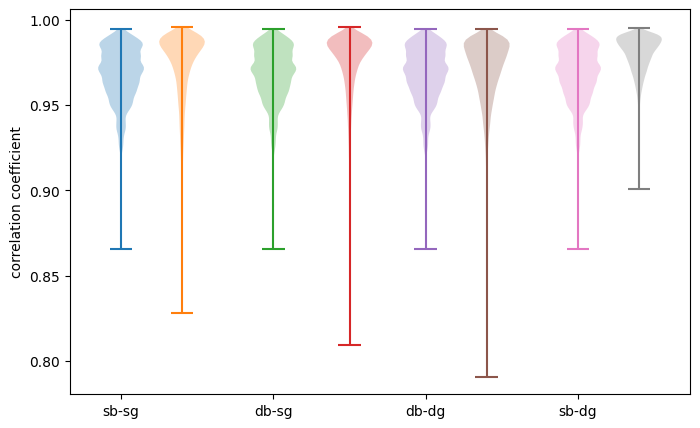

intermediate results:


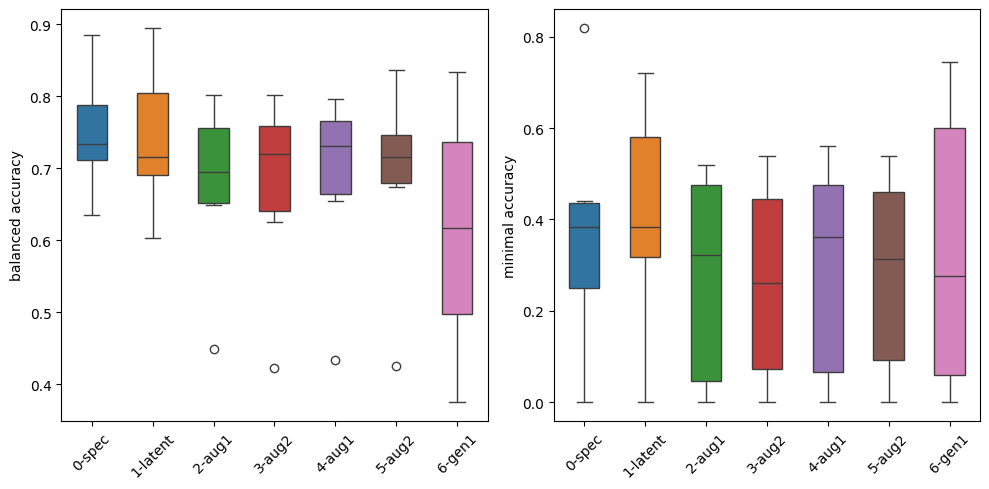

[0 1 3 4 5 6 7 8]
1580/1580 [==============================] - 19709s 12s/step


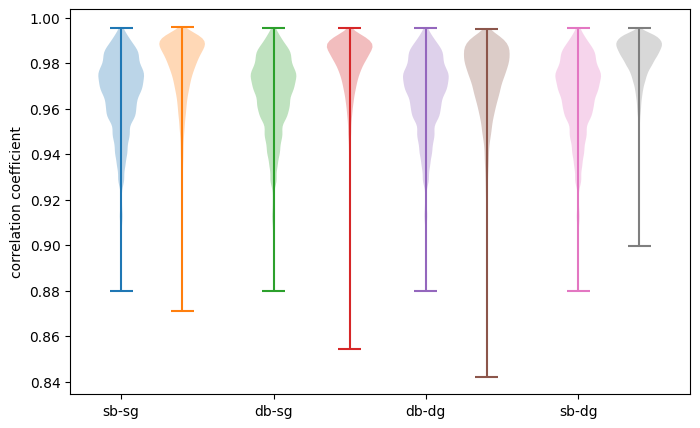

intermediate results:


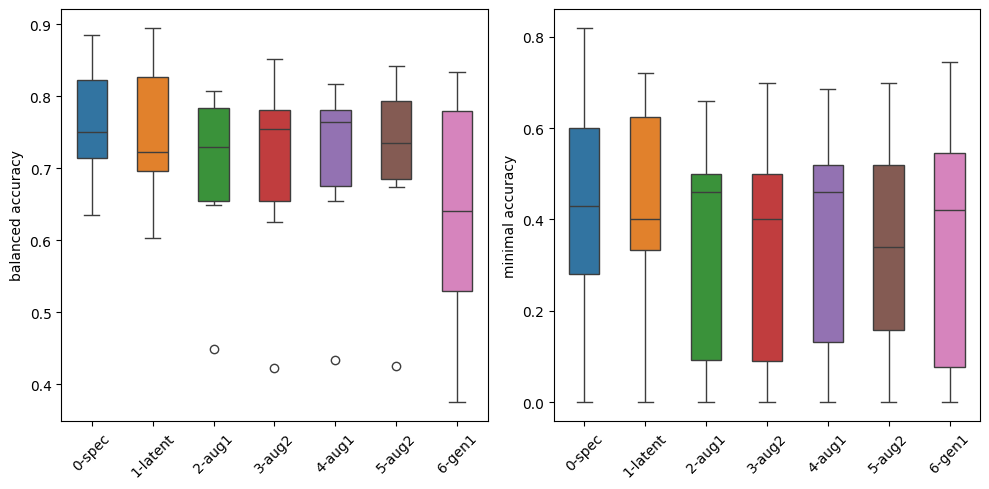

[0 2 3 4 5 6 7 8]
1584/1584 [==============================] - 23986s 15s/step


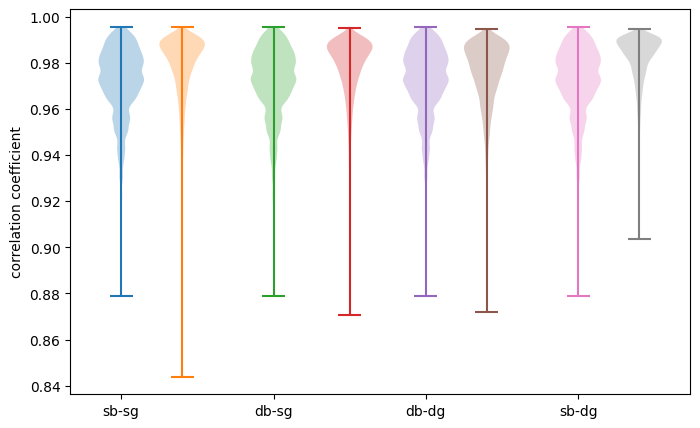

intermediate results:


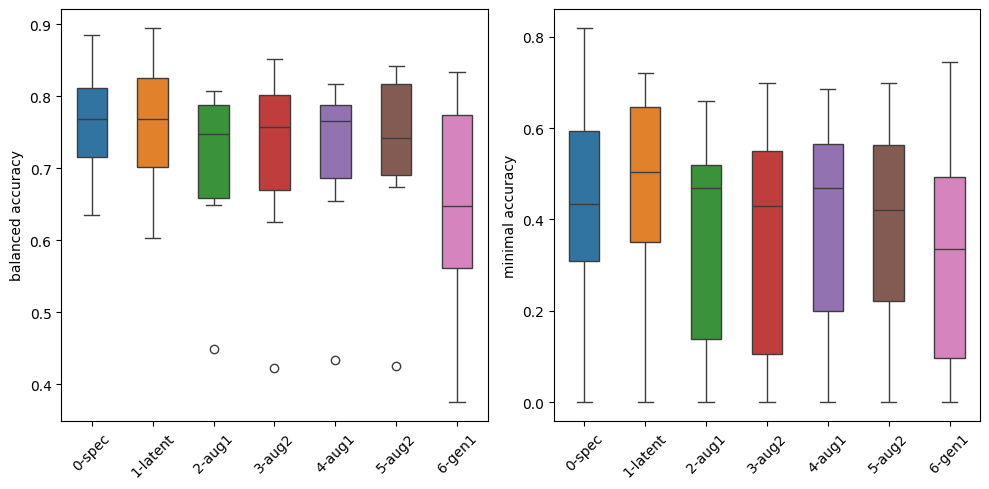

[1 2 3 4 5 6 7 8]
1582/1582 [==============================] - 28766s 18s/step


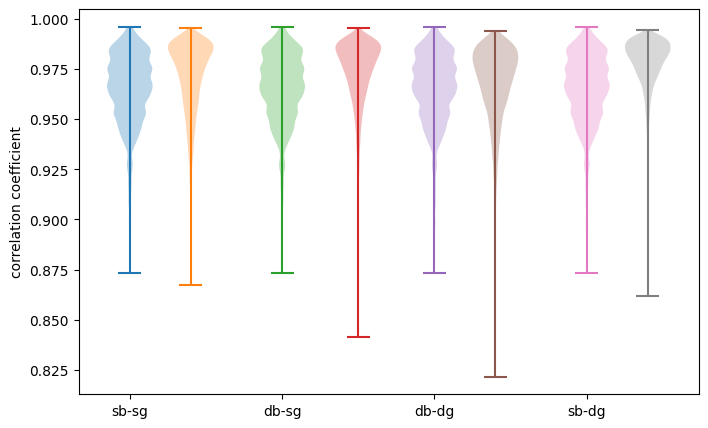

intermediate results:


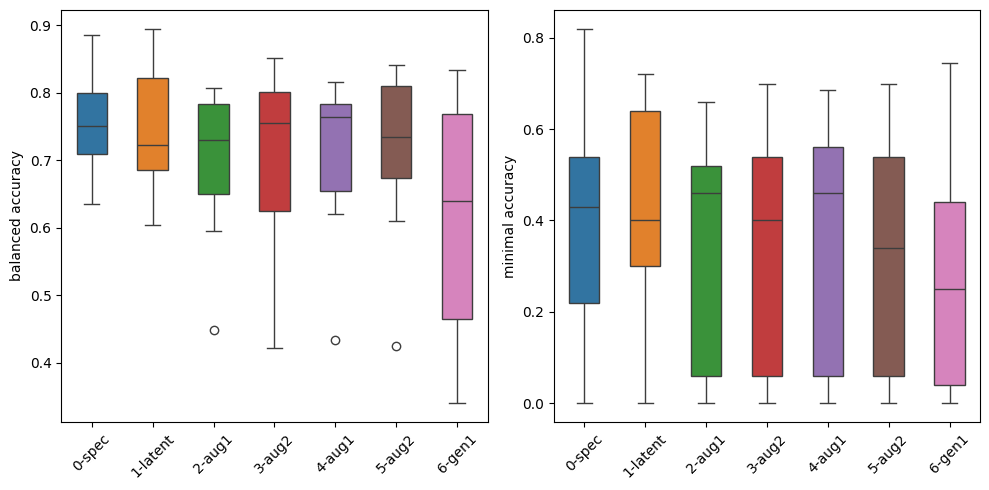

In [5]:
uni_batches = np.unique(batches)
index = np.array(range(len(uni_batches)))
for n_b in [8]:
    accs1 = []; 
    min_accs1 = []; 
    b_trains = []; 
    b_tests = []; 
    methods = []; 
    
    bat = []
    for k in combinations(index, n_b):
        bat.append(k)
    bat = np.row_stack(bat)
    bat = bat[np.array(range(0, bat.shape[0], np.max([1, bat.shape[0]//9]))), :]
    
    for kk in range(bat.shape[0]):
        k = bat[kk,:]
        print(k)
        batch_sel = np.array([uni_batches[i] for i in k])
        
        ix = [] 
        for b in batch_sel:
            if len(ix)<1:
                ix = (batches==b)
            else:
                ix = (ix) | (batches==b)
        ix = np.array(np.argwhere(ix==True)[:,0])

        ix_test_spec = np.array(list(set(range(spec.shape[0])) - set(ix)))

        smp_train = []
        for l in np.unique(labels[ix]):
            smp_train = np.append(smp_train, np.random.choice(ix[np.argwhere(labels[ix]==l)[:,0]], 10, replace=False))
        smp_train = np.array(smp_train, dtype='int32')

        # ix = np.random.choice(ix, len(ix), replace=False)
        acc1, min_acc1, std_acc1, b_test, method = do_PCA_LDA(spec, labels, batches, ix, ix_test_spec, nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc1)
        min_accs1 = np.append(min_accs1, min_acc1)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('0-spec', len(acc1)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc1)))
        
        x, y, g = prep_training(spec[ix,:], labels[ix], batches[ix], n_pairs=40000) 
                
        downsampling = 2**args.n_down
        n_org = x.shape[1]
        n_res = (x.shape[1]//downsampling+1)*downsampling-x.shape[1]
        if n_res>0: 
            x_end = np.fliplr(x[:, -n_res:])
            y_end = np.fliplr(y[:, -n_res:])
            x = np.concatenate([x, x_end], axis=1)
            y = np.concatenate([y, y_end], axis=1)
        res1 = x.shape[1]//downsampling-args.para_shape
    
        train_size = x.shape[0]//10*9
        ix_train = np.random.choice(range(x.shape[0]), train_size, replace=False)
        ix_test = list(set(range(x.shape[0])) - set(ix_train))

        args.n_std = np.mean(np.std(snip(x[:, ix_wn], 10), axis=1))
        args.input_size = (x.shape[1], 1)       
        args.lr=0.00005
        args.epochs = 100
        model = vae.model_vae(args) 
        
        model.wn = wn.copy()
        model.x = x.copy()
        model.y = y.copy()
        model.g = g.copy()
        del x, y, g
        
        model.train_vae(ix_train, ix_test, res1, ratio=1e-4)
        # model.enc.load_weights('enc_weights.h5')
        # model.dec.load_weights('dec_weights.h5')
        ### test generation
        # model.test_vae(ix_test, res1)

        #### test classification
        if n_res>0: 
            x_end = np.fliplr(spec[:, -n_res:])
            spec1 = np.concatenate([spec, x_end], axis=1)
            
        mean, log_var = model.enc(spec1)
        latent = model.sampling(mean, log_var)
        latent = np.array(Flatten()(latent))
        acc2, min_acc2, std_acc2, b_test, method = do_PCA_LDA(latent, labels, batches, ix, ix_test_spec, nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc2)
        min_accs1 = np.append(min_accs1, min_acc2)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('1-latent', len(acc2)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc2)))

        corrs = []
        rand_pair = np.row_stack([np.random.choice(ix, 500, replace=len(ix)<500), np.random.choice(ix_test_spec, 500, replace=len(ix_test_spec)<500)]) 
        for i in range(rand_pair.shape[1]):
            corrs.append([1-spatial.distance.cosine(spec[rand_pair[0, i], :], spec[rand_pair[1, i], :]), np.corrcoef(spec[rand_pair[0, i], :], spec[rand_pair[1, i], :])[0, 1]])
        corrs = np.row_stack(corrs)
        corrs = np.mean(corrs, axis=1)
        y_gen, c_rea, c_gen, g_gen, b_gen = model.gen_spec(spec1[ix,:], paras=corrs, res1=res1)

        ix_sb_sg = (b_gen>0.5) & (g_gen>0.5)
        ix_db_sg = (b_gen<0.5) & (g_gen>0.5)
        ix_sb_dg = (b_gen>0.5) & (g_gen<0.5)
        ix_db_dg = (b_gen<0.5) & (g_gen<0.5)

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        c_gen_sb_sg = c_gen[ix_sb_sg]
        c_gen_db_sg = c_gen[ix_db_sg]
        c_gen_db_dg = c_gen[ix_db_dg]
        c_gen_sb_dg = c_gen[ix_sb_dg]

        c_rea_sb_sg = c_rea[ix_sb_sg]
        c_rea_db_sg = c_rea[ix_db_sg]
        c_rea_db_dg = c_rea[ix_db_dg]
        c_rea_sb_dg = c_rea[ix_sb_dg]
        
        ax.violinplot(c_rea_sb_sg, positions=[0], widths=0.3)
        ax.violinplot(c_gen_sb_sg, positions=[0.4], widths=0.3)
        ax.violinplot(c_rea_db_sg, positions=[1.0], widths=0.3)
        ax.violinplot(c_gen_db_sg, positions=[1.5], widths=0.3)
        ax.violinplot(c_rea_db_dg, positions=[2.0], widths=0.3)
        ax.violinplot(c_gen_db_dg, positions=[2.4], widths=0.3)
        ax.violinplot(c_rea_sb_dg, positions=[3.0], widths=0.3)
        ax.violinplot(c_gen_sb_dg, positions=[3.4], widths=0.3)
        ax.set_ylabel('correlation coefficient', fontsize=10)
        ax.set_xticks([0, 1, 2, 3], ('sb-sg', 'db-sg', 'db-dg', 'sb-dg'), fontsize=10) 
        plt.show()
        del spec1
        
        with open(dirname(abspath(os.getcwd())) + '/datasets/data_gen_' + str(kk) + '.pkl', 'wb') as f:
            pickle.dump([y_gen, c_gen, c_rea, g_gen, b_gen], f)
            
        # ix_aug = np.random.choice(ix, len(ix)//2, replace=False)
        c_bins = np.asarray(np.linspace(85, 100, n_spec_gen)/100.0)

        ### augmentation: replace half of the real data with generated spectra (all batches)
        spec_train = []
        label_train = []
        batch_train = []
        for i in range(len(ix)):
            if i%2==0: continue
            spec_train.append(spec[ix[i], :])
            label_train = np.append(label_train, labels[ix[i]])  
            batch_train = np.append(batch_train, batches[ix[i]])  
            g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            c_in_out = c_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            ix_pair = np.argwhere((g_in_out>0.5))[:,0]
            ix_pair = np.random.choice(ix_pair, 1, replace=False)
            spec_train.append(y_gen[i*n_spec_gen+ix_pair, :1376])
            label_train = np.append(label_train, labels[ix[i]])  
            for j in [ix_pair]:
                if b_in_out[j]<0.5:
                    batch_train = np.append(batch_train, 'new_Batch')  
                else:
                    batch_train = np.append(batch_train, batches[ix[i]])  
        spec_train = np.row_stack(spec_train)

        acc3, min_acc3, std_acc3, b_test, method = do_PCA_LDA(np.concatenate([spec_train, spec[ix_test_spec, :]], axis=0), 
                                        np.concatenate([label_train, labels[ix_test_spec]]), np.concatenate([batch_train, batches[ix_test_spec]]), 
                                        np.array(range(len(label_train))), np.array(range(len(label_train), len(label_train)+len(ix_test_spec))), nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc3)
        min_accs1 = np.append(min_accs1, min_acc3)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('2-aug1', len(acc3)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc3)))
        
        ### augmentation: replace half of the real data with generated spectra (new batch)
        spec_train = []
        label_train = []
        batch_train = []
        for i in range(len(ix)):
            if i%2==0: continue
            spec_train.append(spec[ix[i], :])
            label_train = np.append(label_train, labels[ix[i]])  
            batch_train = np.append(batch_train, batches[ix[i]])  
            g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            c_in_out = c_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            ix_pair = np.argwhere((g_in_out>0.5) & (b_in_out<0.5))[:,0]
            ix_pair = np.random.choice(ix_pair, 1, replace=False)
            spec_train.append(y_gen[i*n_spec_gen+ix_pair, :1376])
            label_train = np.append(label_train, labels[ix[i]])  
            for j in [ix_pair]:
                if b_in_out[j]<0.5:
                    batch_train = np.append(batch_train, 'new_Batch')  
                else:
                    batch_train = np.append(batch_train, batches[ix[i]])  
        spec_train = np.row_stack(spec_train)
        
        acc4, min_acc4, std_acc4, b_test, method = do_PCA_LDA(np.concatenate([spec_train, spec[ix_test_spec, :]], axis=0), 
                                        np.concatenate([label_train, labels[ix_test_spec]]), np.concatenate([batch_train, batches[ix_test_spec]]), 
                                        np.array(range(len(label_train))), np.array(range(len(label_train), len(label_train)+len(ix_test_spec))), nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc4)
        min_accs1 = np.append(min_accs1, min_acc4)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('3-aug2', len(acc4)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc4)))

        spec_train = []
        label_train = []
        batch_train = []
        for i in range(len(ix)):
            spec_train.append(spec[ix[i], :])
            label_train = np.append(label_train, labels[ix[i]])  
            batch_train = np.append(batch_train, batches[ix[i]])  
            g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            c_in_out = c_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            ix_pair = np.argwhere((g_in_out>0.5))[:,0]
            ix_pair = np.random.choice(ix_pair, 1, replace=False)
            spec_train.append(y_gen[i*n_spec_gen+ix_pair, :1376])
            label_train = np.append(label_train, labels[ix[i]])  
            for j in [ix_pair]:
                if b_in_out[j]<0.5:
                    batch_train = np.append(batch_train, 'new_Batch')  
                else:
                    batch_train = np.append(batch_train, batches[ix[i]])  
        spec_train = np.row_stack(spec_train)

        acc3, min_acc3, std_acc3, b_test, method = do_PCA_LDA(np.concatenate([spec_train, spec[ix_test_spec, :]], axis=0), 
                                        np.concatenate([label_train, labels[ix_test_spec]]), np.concatenate([batch_train, batches[ix_test_spec]]), 
                                        np.array(range(len(label_train))), np.array(range(len(label_train), len(label_train)+len(ix_test_spec))), nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc3)
        min_accs1 = np.append(min_accs1, min_acc3)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('4-aug1', len(acc3)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc3)))
        
        ### augmentation: replace half of the real data with generated spectra (new batch)
        spec_train = []
        label_train = []
        batch_train = []
        for i in range(len(ix)):
            spec_train.append(spec[ix[i], :])
            label_train = np.append(label_train, labels[ix[i]])  
            batch_train = np.append(batch_train, batches[ix[i]])  
            g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            c_in_out = c_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            ix_pair = np.argwhere((g_in_out>0.5) & (b_in_out<0.5))[:,0]
            ix_pair = np.random.choice(ix_pair, 1, replace=False)
            spec_train.append(y_gen[i*n_spec_gen+ix_pair, :1376])
            label_train = np.append(label_train, labels[ix[i]])  
            for j in [ix_pair]:
                if b_in_out[j]<0.5:
                    batch_train = np.append(batch_train, 'new_Batch')  
                else:
                    batch_train = np.append(batch_train, batches[ix[i]])  
        spec_train = np.row_stack(spec_train)
        
        acc4, min_acc4, std_acc4, b_test, method = do_PCA_LDA(np.concatenate([spec_train, spec[ix_test_spec, :]], axis=0), 
                                        np.concatenate([label_train, labels[ix_test_spec]]), np.concatenate([batch_train, batches[ix_test_spec]]), 
                                        np.array(range(len(label_train))), np.array(range(len(label_train), len(label_train)+len(ix_test_spec))), nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc4)
        min_accs1 = np.append(min_accs1, min_acc4)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('5-aug2', len(acc4)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc4)))
        
        ### transfer learning: use same number of generated spectra (all batch)
        spec_train = [] #[spec[ix_aug, :].copy()]
        label_train = [] #labels[ix_aug].copy()
        batch_train = [] #batches[ix_aug].copy()
        for i in range(len(ix)):
            g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            c_in_out = c_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
            ix_pair = np.argwhere((g_in_out>0.5))[:,0]
            ix_pair = np.random.choice(ix_pair, 1, replace=False)
            spec_train.append(y_gen[i*n_spec_gen+ix_pair, :1376])
            label_train = np.append(label_train, labels[ix[i]])  
            for j in [ix_pair]:
                if b_in_out[j]<0.5:
                    batch_train = np.append(batch_train, 'new_Batch')  
                else:
                    batch_train = np.append(batch_train, batches[ix[i]])  
        spec_train = np.row_stack(spec_train)

        # ix_ecoli = np.argwhere(label_train=='E-coli')[:,0]
        # for b in np.unique(batch_train[ix_ecoli]):
        #     sp = np.mean(spec_train[ix_ecoli[batch_train[ix_ecoli] == b], :], 0)
        #     plt.plot(wn, sp)
        # plt.ylabel('Intensity /arb.u.', fontsize=10)
        # plt.xlabel('Wavenumber / $\mathregular{cm^{-1}}$', fontsize=10)
        # plt.title('E-coli')
        # plt.show()
        
        acc5, min_acc5, std_acc5, b_test, method = do_PCA_LDA(np.concatenate([spec_train, spec[ix_test_spec, :]], axis=0), 
                                        np.concatenate([label_train, labels[ix_test_spec]]), np.concatenate([batch_train, batches[ix_test_spec]]), 
                                        np.array(range(len(label_train))), np.array(range(len(label_train), len(label_train)+len(ix_test_spec))), nPCs=[10], ix_wn=None)
        accs1 = np.append(accs1, acc5)
        min_accs1 = np.append(min_accs1, min_acc5)
        b_tests = np.append(b_tests, b_test)
        methods = np.append(methods, np.resize('6-gen1', len(acc5)))
        b_trains = np.append(b_trains, np.resize(str(kk), len(acc5)))  
        
        print('intermediate results:')
        accs_all = []
        min_accs_all = []
        for m in np.unique(methods):
            accs_all.append(accs1[methods==m])
            min_accs_all.append(min_accs1[methods==m])
        accs_all = np.column_stack(accs_all)
        min_accs_all = np.column_stack(min_accs_all)
        
        fig, ax = plt.subplots(1, 2,  figsize=(10, 5))
        sns.boxplot(data=accs_all, width=0.5, ax=ax[0])
        ax[0].set_xticks(range(len(np.unique(methods))), np.unique(methods), rotation=45)
        ax[0].set_ylabel('balanced accuracy')
        sns.boxplot(data=min_accs_all, width=0.5, ax=ax[1])
        ax[1].set_xticks(range(len(np.unique(methods))), np.unique(methods), rotation=45)
        ax[1].set_ylabel('minimal accuracy')
        
        # sns.boxplot(data=std_accs_all, width=0.5, ax=ax[2])
        # ax[2].set_xticks(range(len(np.unique(methods))), np.unique(methods), rotation=45)
        # ax[2].set_ylabel('std of accuracy')
        plt.tight_layout()
        plt.show()
        plt.close()

    with open(dirname(abspath(os.getcwd())) + '/results/accs_' + str(n_b) + '_batch.pkl', 'wb') as f:
        pickle.dump([accs1, min_accs1, b_trains, b_tests, methods], f)